In [56]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, MiniBatchKMeans, KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from sklearn import metrics
from stop_words import get_stop_words
import pymorphy2
import string

In [93]:
df = pd.read_csv("books.csv")["review"].to_frame()
morph = pymorphy2.MorphAnalyzer()
stop_words = get_stop_words('ru')

In [72]:
def delete_chars(text):
    chars = ["«", "»", "…", "–", "(", ")", "[", "]", "#", ",", ".", "1", "2", "3", "4", "5", "6", "7", "8", "9", "0", ":", "+", "-", "/", "\\", "-", "!", "\"", "?"]
    
    for char in chars:
        text = str(text).replace(char, "")
        
    return text

def clean_texts(reviews):
    reviews_clear = []

    for text in reviews:
        clear_text = ''

        text = delete_chars(text)

        for word in text.split():
            normal_form = morph.parse(word)[0].normal_form

            if not normal_form in stop_words:
                clear_text += normal_form + " "

        reviews_clear.append(clear_text)
    
    return reviews_clear

In [94]:
reviews_clear_pred = clean_texts(df["review"])

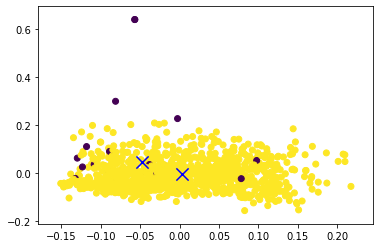

In [35]:
vec = TfidfVectorizer()
vec.fit(reviews_clear)
features = vec.transform(reviews_clear)

cls = MiniBatchKMeans(n_clusters=2, random_state=0,
                      batch_size = 45, max_no_improvement = 10, 
                      verbose = 0)
cls.fit(features)

pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [104]:
reviews_data = pd.read_csv("reviews.csv")
reviews_clear = clean_texts(reviews_data["content"])
true_labels = [1 if label > 3.5 else 0 for label in reviews_data["label"]]

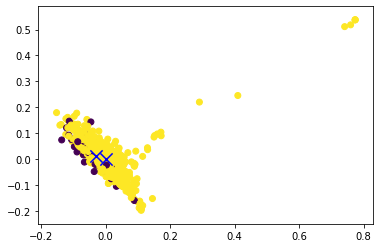

In [105]:
vec = TfidfVectorizer()
vec.fit(reviews_clear)
features = vec.transform(reviews_clear)

cls = MiniBatchKMeans(n_clusters=2, random_state=0,
                      batch_size = 50, max_no_improvement = 10, 
                      verbose = 0)
cls.fit(features)

pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(features.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(features))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [106]:
from sklearn.metrics import homogeneity_score
homogeneity_score(true_labels, cls.predict(features))

0.000321449367179924

In [86]:
true_k = 2

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(reviews_clear)

model = KMeans(n_clusters=true_k, init='k-means++', max_iter=1000, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print


Top terms per cluster:
Cluster 0:
 книга
 читать
 автор
 интересный
 история
 сюжет
 герой
 роман
 самый
 свой
Cluster 1:
 книга
 свой
 история
 друг
 герой
 самый
 мир
 автор
 ребёнок
 любовь


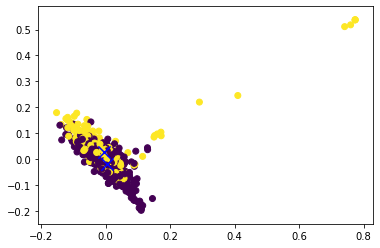

In [87]:
pca = PCA(n_components=2, random_state=0)
reduced_features = pca.fit_transform(X.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(model.cluster_centers_)

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=model.predict(X))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')

In [100]:
for ind in range(len(reviews_data)):
    if reviews_data["label"][ind] <= 3.5:
        print(reviews_data["content"][ind])
    print()

Я могу однозначно сказать, что книга мне понравилась, но определенно она вызвала массу эмоций и заставила о многом задуматься. Книга такая печальная, пронизанная чувством тоскливого одиночества.
Это история семьи Ли, которая пытается справиться со смертью дочери и сестры.
Однажды утром шестнадцатилетия Лидия не спустилась к завтраку, а через несколько дней ее мертвую нашли на дне озера. Полиция считает, что самая вероятная причина смерти - самоубийство, семья, особенно мать, отказываются в это верить. И по завязке кажется, что нас ожидает триллер, к тому же в аннотации идет сравенение с Лорой Палмер. Но триллера тут нет, просто драма одной семьи, ее история, цепочка разных событий, которые привели к трагедии.
Действие книги разворачивается в 60-70х годах, и это накладывает определенные условия, так как Мэрилин белокожая блондинка-американка, а Джеймс - сын китайских эмигрантов, а межрасовые браки не то, что не приветствуются, а даже где-то являются уголовным преступлением. Несмотря на 